In [114]:
import numpy as np
import pandas as pd

import seaborn as sbn
import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams  
rcParams['figure.figsize'] = (15, 15) #Size of figure  
rcParams['figure.dpi'] = 125
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"
% matplotlib inline

## plotting spatial stuff

In [2]:
pos = pd.read_csv('inferred_locations.csv')

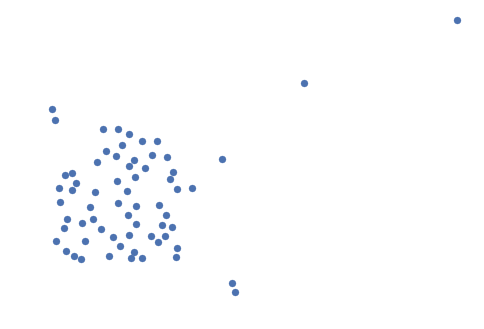

In [3]:
sbn.set(style="white")
plt.scatter(pos['x'],pos['y'])
sbn.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.axis('off')
plt.savefig('locations.png', transparent=True)

## plotting mpc

In [4]:
import scipy.io as sio

In [5]:
mpcperfect = sio.loadmat('mpcperfect.mat')

In [6]:
mpcperfect

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun  7 19:27:44 2017',
 '__version__': '1.0',
 'custWaiting': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'numVehiclesRebalancing': array([[ 0],
        [ 0],
        [ 0],
        ..., 
        [52],
        [52],
        [ 0]], dtype=uint16),
 'numVehiclesServing': array([[  0],
        [  0],
        [  0],
        ..., 
        [642],
        [643],
        [  0]], dtype=uint16)}

In [7]:
mpcperfect['numVehiclesRebalancing'][:,0].shape

(14400,)

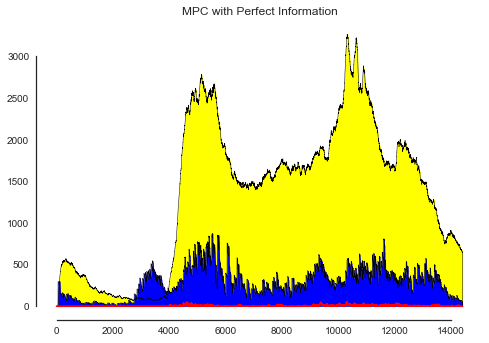

In [8]:
sbn.set(style="white")
plt.fill_between(range(14400),mpcperfect['numVehiclesServing'][:,0], color='yellow')
plt.plot(range(14400),mpcperfect['numVehiclesServing'][:,0], color='black', linewidth=0.5)
plt.fill_between(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='blue')
plt.plot(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='black', linewidth=0.5)
plt.plot(range(14400),mpcperfect['custWaiting'].sum(axis=1), color='red')

sbn.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=True)
plt.title('MPC with Perfect Information')

In [126]:
mpc_perfect = sio.loadmat('MPC_Perf_5000v_rev3.mat')
mpc_lstm = sio.loadmat('MPC-LSTM5000v_rev3.mat')
reactive = sio.loadmat('REACTIVE5000v_rev3.mat')
mpc_empty = sio.loadmat('MPC-EMPTY5000v_rev3.mat')

In [127]:
mpc_perfect['numVehiclesRebalancing'][:,0].shape

(14400,)

In [221]:
scenarios = [
    {
        'data': mpc_perfect,
        'style': {
            'stroke': '--',
            'color': 'gray'
        },
        'name': 'MPC Perfect Information'
    },
    {
        'data': mpc_lstm,
        'style': {
            'stroke': '-',
            'color': 'blue'
        },
        'name': 'MPC LSTM Predictions'
    },
    {
        'data': reactive,
        'style': {
            'stroke': '-.',
            'color': 'green'
        },
        'name': 'Reactive'
    },
]

In [129]:
for scenario in scenarios:
    scenario['data']['numVehiclesServing'] = scenario['data']['numVehiclesBusy']-scenario['data']['numVehiclesRebalancing']
    scenario['data']['totCustWaiting'] = scenario['data']['custWaiting'].sum(axis=1)
    scenario['data']['numVehiclesEmptyTravel'] = scenario['data']['numVehiclesDrivingToPickup']+scenario['data']['numVehiclesRebalancing']

In [248]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['numDelivered'][0][0]

MPC Perfect Information 211009
MPC LSTM Predictions 211118
Reactive 210702


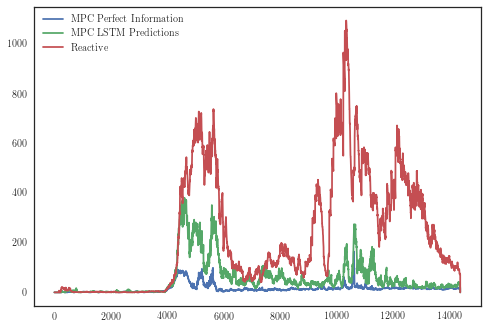

In [350]:
for scenario in scenarios:
    plt.plot(scenario['data']['numVehiclesDrivingToPickup'],#+ 
             #scenario['data']['numVehiclesIdle'],# + 
             #scenario['data']['numVehiclesRebalancing'],
        label=scenario['name']
    )
plt.legend()

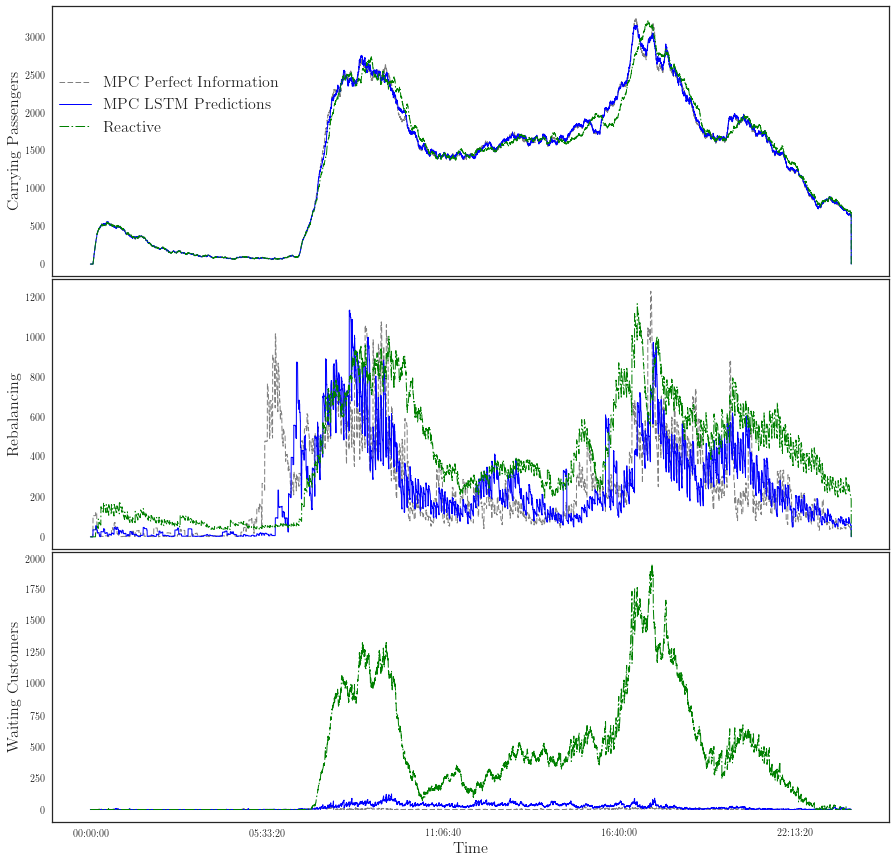

In [222]:
sbn.set(style="white")

start = datetime.datetime(2016, 1, 21, hour =0)
stepsize = datetime.timedelta(seconds = 6)
tindex = [(start + stepsize * j).time() for j in range(14400)]

titles = ['Carrying Passengers', 'Rebalancing', 'Waiting Customers']
series = ['numVehiclesDrivingToDest', 'numVehiclesEmptyTravel', 'totCustWaiting']


f, axes = plt.subplots(3, sharex=True, sharey=False,figsize=(15,15));
for i in range(3):
    for j, scenario in enumerate(scenarios):
        axes[i].plot(
            tindex, scenario['data'][series[i]],
            color = scenario['style']['color'],
            linestyle = scenario['style']['stroke'],
            linewidth=1,
            label = scenario['name']
                );
        axes[i].set_ylabel(titles[i], fontsize=16)

f.subplots_adjust(hspace=0.01);
axes[-1].set_xlabel('Time', fontsize = 16)
axes[0].legend(loc=(0,0.5), fontsize=16)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.savefig('summarized_results_plot.pdf',bbox_inches='tight')

## plotting predictions

In [153]:
paxout = pd.read_csv('ignored_assets/paxout_table.csv')
paxout['time_bucket'] = pd.to_datetime(paxout['time_bucket'])
real = paxout[paxout['time_bucket'].dt.date == datetime.date(2016, 1, 21)]
real = real.set_index('time_bucket')

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


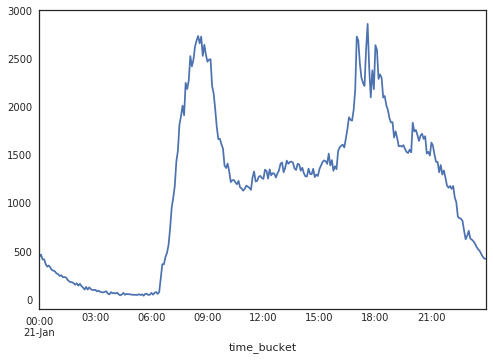

In [157]:
plt.rcParams['text.usetex'] = False
real.sum(axis=1).plot()

In [179]:
# params
stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-21 00:00:00')
end = pd.to_datetime('2016-01-22 00:00:00')

tommydf = pd.read_csv('ignored_assets/tommy_predictions.csv')
tommydf['predicted_at'] = pd.to_datetime(tommydf['predicted_at'])
tommydf['time_bucket'] = pd.to_datetime(tommydf['timestamp'])
tommydf = tommydf.drop('timestamp', axis = 1)

wrong_vals = tommydf['time_bucket'][tommydf['time_bucket'] >= pd.to_datetime('2016-01-22T00:00:00.000000000')].unique()
corrected_vals = [pd.to_datetime('2016-01-22T00:00:00.000000000') + j*stepsize for j in range(int(horizon / stepsize))]
for i in range(len(wrong_vals)):
    tommydf['time_bucket'][tommydf['time_bucket'] == wrong_vals[i]] = corrected_vals[i]

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [210]:
12 % 12

0

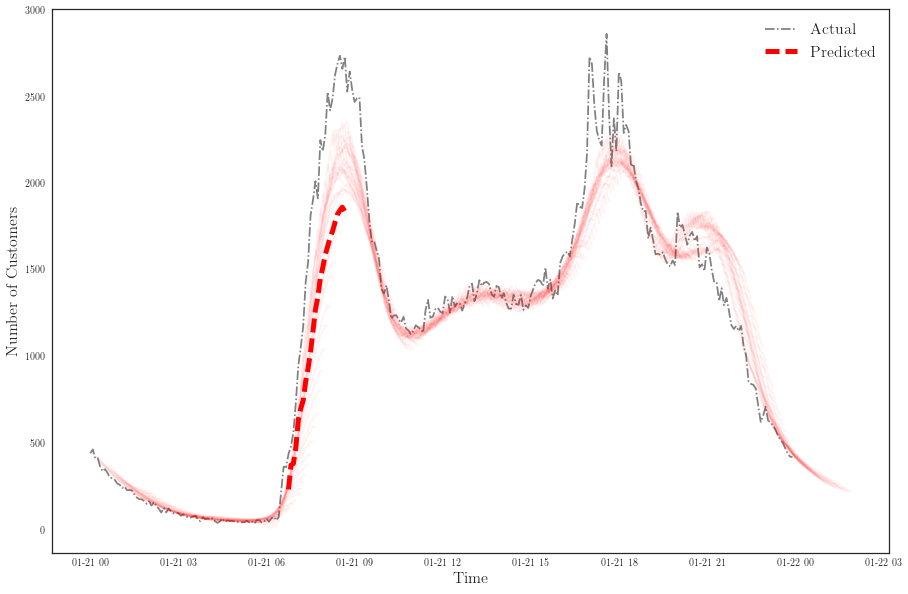

In [220]:
sbn.set(style="white")
plt.figure(figsize=(15,10))
plt.plot(real.index, real.sum(axis=1).values, color='gray', linestyle='-.', label='Actual')

for i,t in enumerate(real.index):
    #if i % 12 != 0: continue
    tempdf = tommydf[tommydf['predicted_at'] == t].drop('predicted_at',axis=1).set_index('time_bucket').sum(axis=1)
    if i == 80:
        plt.plot(tempdf.index, tempdf.values.round(), color='r', linestyle='--', alpha=1,linewidth=5, label='Predicted')
    else:
        plt.plot(tempdf.index, tempdf.values.round(), color='r', linestyle='-', alpha=0.05)

plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(fontsize = 16)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.savefig('total_demand_predictions.pdf',bbox_inches='tight')

In [223]:
real.sum().sum()

330396

In [224]:
330396. / 5000.

66.0792

In [227]:
211118. / 330396.

0.6389847334713495

In [243]:
(scenario['data']['numVehiclesDrivingToPickup'] + scenario['data']['numVehiclesDrivingToDest'] + scenario['data']['totCustWaiting'][:,None])[-3]

array([742], dtype=uint64)

In [238]:
scenario['data']['totCustWaiting'].shape

(14400,)

In [239]:
scenario['data']['numVehiclesDrivingToDest'].shape

(14400, 1)

In [245]:
real.tail().sum().sum()

2258

In [251]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['numVehiclesEmptyTravel'].mean()

MPC Perfect Information 251.103194444
MPC LSTM Predictions 241.226736111
Reactive 395.769305556


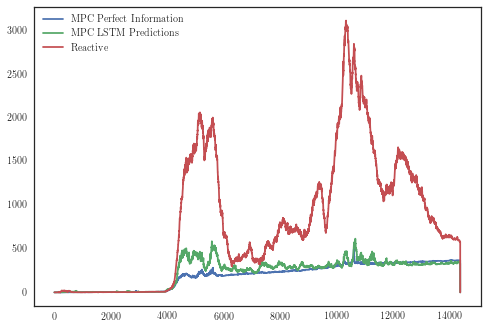

In [281]:
for scenario in scenarios:
    plt.plot(scenario['data']['cumNumCustomers'], label=scenario['name'])

plt.legend()

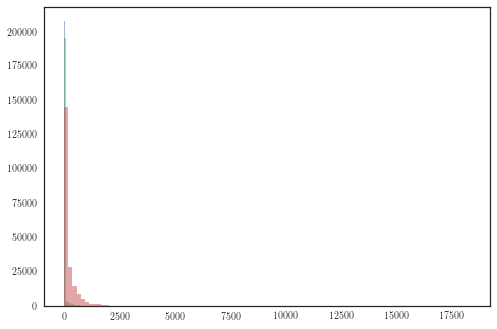

In [276]:
for scenario in scenarios:
    plt.hist(scenario['data']['allWaitTimes'], label=scenario['name'], bins=100, alpha=0.5)

In [278]:
for scenario in scenarios:
    print scenario['name'], scenario['data']['allWaitTimes'].std()

MPC Perfect Information 60.8688610766
MPC LSTM Predictions 127.93303339
Reactive 376.426546584


In [279]:
for scenario in scenarios:
    print scenario['name'], scenario['data']['LinkTime'].max()

MPC Perfect Information 1000000000.0
MPC LSTM Predictions 1000000000.0
Reactive 1000000000.0


In [292]:
for scenario in scenarios:
    print scenario['name'], (scenario['data']['cumNumCustomers'][-2] + scenario['data']['numDelivered'] + scenario['data']['numVehiclesDrivingToDest'][-2])[0][0]

MPC Perfect Information 211999
MPC LSTM Predictions 212092
Reactive 211951


In [345]:
unpicked = np.zeros(66)
picked_not_del = np.zeros(66)
delivered = np.zeros(66)
incongruent = np.zeros(66)
self_looper = np.zeros(66)
for i in range(scenario['data']['cc'] - 1):
    cus = scenario['data']['customer'][0][i]
    # unpicked
    if cus[-2][0][0] == 0:
        unpicked[cus[2]-1] += 1
    elif cus[-1][0][0] == 0:
        picked_not_del[cus[2]-1] += 1
    else:
        delivered[cus[2]-1] += 1
    
    if cus[-2][0][0] == 0 and cus[-1][0][0] == 1:
        incongruent[cus[2]-1] += 1
    
    if cus[2] == cus[3]:
        self_looper[cus[2]-1] += 1

In [349]:
self_looper.sum()

118938.0

In [341]:
print len(scenario['data']['station'][0][56][2][0]), unpicked[56]

16812 16812.0


In [338]:
for c in scenario['data']['station'][0][56][2][0]:
    cus = scenario['data']['customer'][0][c]
    veh = car = scenario['data']['car'][0][v]

array([    21,     48,     59, ..., 329907, 329911, 329934], dtype=int32)

In [329]:
speeds = np.zeros(5000)

for v in range(5000):
    car = scenario['data']['car'][0][v]
    speeds[v] = car[-1]

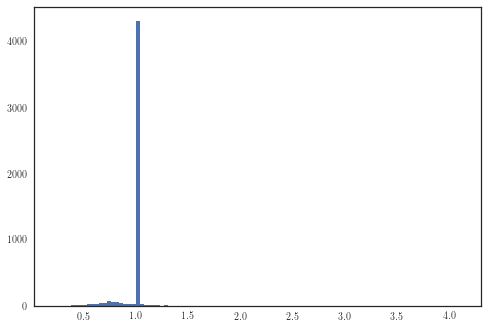

In [333]:
plt.hist(speeds, bins = 100);

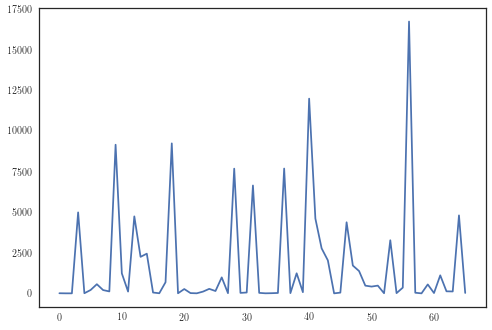

In [309]:
plt.plot(unpicked)

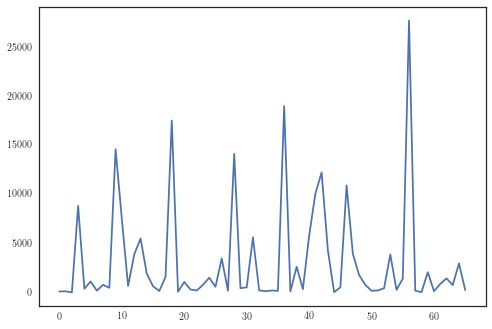

In [311]:
plt.plot(delivered)

In [312]:
print unpicked.argmax(), delivered.argmax()

56 56


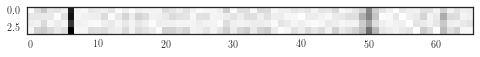

In [321]:
D = scenario['data']['LinkTime']
np.fill_diagonal(D,0)
plt.imshow(D[54:58])

In [336]:
print 'Unpicked: ',unpicked.sum(), 'On their way', picked_not_del.sum()

Unpicked:  119253.0 On their way 131.0
